In [36]:
from standard_transform import minnie_ds

In [37]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.stats import proportion
import warnings
from tqdm import tqdm
from scipy.optimize import minimize
%matplotlib inline

In [3]:
import sys
sys.path.append('../src')

import neighbors
from neighbors import dist, connect_stats, plot

In [4]:
client = CAVEclient('minnie65_phase3_v1')

In [5]:
soma_df = client.materialize.tables['aibs_metamodel_mtypes_v661_v2']().query(
    split_positions=True,
    desired_resolution=[1,1,1],
)

soma_df.drop_duplicates(subset=["pt_root_id"], inplace=True, keep=False)

The `client.materialize.tables` interface is experimental and might experience breaking changes before the feature is stabilized.


In [6]:
def get_cell_tables(
    root_id,
    syn_df,
    soma_df,
    tform_ds,
    cell_type_column="cell_type",
    bin_width=25,
    upper_distance_limit=300,
    soma_position=None,
):
    if soma_position is None:
        soma_position = soma_df.query("pt_root_id == @root_id")[
            ["pt_position_x", "pt_position_y", "pt_position_z"]
        ].values[0]

    target_df = neighbors.make_tables.build_tables(
        soma_position,
        syn_df,
        soma_df,
        soma_position_column=["pt_position_x", "pt_position_y", "pt_position_z"],
        radial_function=tform_ds.streamline_nm.radial_distance,
    )

    not_connected, connected, bins = neighbors.make_tables.compute_confidence_intervals(
        target_df,
        bin_width=bin_width,
        upper_distance_limit=upper_distance_limit,
        cell_type_column=cell_type_column,
    )

    X = tform_ds.streamline_nm.radial_points(
        soma_position, target_df[["pt_position_x", "pt_position_y", "pt_position_z"]]
    )
    target_df["rel_x"] = X[:, 0]
    target_df["rel_z"] = X[:, 2]

    return soma_position, syn_df, target_df, connected, not_connected, bins


def fit_distance_connectivity(
    connected,
    not_connected,
    target_df,
    bins,
    syn_threshold=0,
    cell_type=None,
    cell_type_column="cell_type",
):
    if cell_type is not None:
        target_df = target_df.query(f"{cell_type_column} == @cell_type").reset_index(
            drop=True
        )

    params = neighbors.connect_stats.fit_loglikelihood(
        target_df.query("num_syn > @syn_threshold"),
        target_df.query("num_syn <= @syn_threshold"),
    )

    xs_fit = np.arange(0, np.max(bins))
    ys_fit = neighbors.connect_stats.probfunct(
        params,
        xs_fit,
    )

    return params, xs_fit, ys_fit


def connected_scatterplot(
    soma_position,
    target_df,
    x="rel_x",
    y="rel_z",
    num_syn_col="num_syn",
    dist_lim=200,
    sizes=(3, 100),
    syn_scale_max=15,
    palette="crest",
    ax=None,
):
    if ax is None:
        ax = plt.gca()
    sns.scatterplot(
        x=x,
        y=y,
        s=2,
        color=(0.5, 0.5, 0.5),
        alpha=0.4,
        data=target_df,
        ax=ax,
    )
    sns.scatterplot(
        x=x,
        y=y,
        size="num_syn",
        sizes=sizes,
        hue="num_syn",
        size_norm=(1, syn_scale_max),
        hue_norm=(1, syn_scale_max),
        palette=palette,
        data=target_df.query(f"{num_syn_col}>0"),
        linewidth=0.25,
        edgecolor="k",
        zorder=10,
        ax=ax,
    )

    sns.scatterplot(
        x=[0], y=[0], s=100, color="k", marker="*", edgecolor="w", zorder=20, ax=ax
    )
    ax.set_xlim(-dist_lim, dist_lim)
    ax.set_ylim(-dist_lim, dist_lim)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([-dist_lim, 0, dist_lim])
    ax.set_yticks([-dist_lim, 0, dist_lim])
    ax.legend().set_visible(False)
    ax.set_aspect("equal")
    pass


def probability_vs_distance(
    xs,
    ys,
    yerr,
    params,
    dist_limit=200,
    conn_color="r",
    conn_line="-",
    base_color="k",
    base_line=":",
    ax=None,
):
    if ax is None:
        ax = plt.gca()

    xs_fit = np.linspace(0, np.max(xs), 100)
    ys_fit = neighbors.connect_stats.probfunct(params, xs_fit)

    ax.errorbar(
        xs,
        ys,
        yerr=yerr,
        color=base_color,
        marker="o",
        linestyle=base_line,
        markersize=3,
        linewidth=2,
        zorder=0,
    )

    ax.plot(
        xs_fit,
        ys_fit,
        color=conn_color,
        linewidth=1,
        linestyle=conn_line,
        label=f"model:\n$p_{{max}}$={params[0]:.2f}\nsigma={params[1]:.0f}$\mu m$\nmu={params[2]:0.0f}$\mu m$",
        zorder=10,
    )

    ax.set_ylim(-0.02, 1.02)
    ax.set_xlim(-3, dist_limit)
    ax.legend()
    ax.set_xlabel("Distance")
    pass


def connected_amount(
    target_df,
    distance_col="r",
    num_syn_col="num_syn",
    bins=None,
    dist_limit=200,
    ax=None,
):
    if ax is None:
        ax = plt.gca()
    if bins is None:
        bins = (30,)

    sns.histplot(
        x=distance_col,
        data=target_df,
        bins=bins,
        element="step",
        color="gray",
        fill=True,
        alpha=0.5,
        linewidth=0,
        ax=ax,
    )

    sns.histplot(
        x=distance_col,
        data=target_df.query(f"{num_syn_col}>0"),
        bins=bins,
        element="step",
        color="black",
        fill=True,
        alpha=0.5,
        linewidth=0,
        ax=ax,
    )
    ax.set_xlabel("Distance")

    ax.set_yscale("log")
    ax.set_xlim(-3, dist_limit)
    pass


def fit_distance_parameters(
    cell_type,
    connected,
    not_connected,
    target_df,
    bins,
    cell_type_column="cell_type",
    num_syn_column="num_syn",
):
    params = neighbors.connect_stats.fit_loglikelihood(
        target_df.query(f"{cell_type_column} == @cell_type and {num_syn_column}>0"),
        target_df.query(f"{cell_type_column} == @ct and {num_syn_column}==0"),
    )
    yval, yerr = neighbors.connect_stats.compute_binned_errorbars(
        connected[ct],
        not_connected[ct],
    )
    bins_x = np.diff(bins) / 2 + bins[:-1]

    return params, (bins_x, yval, yerr)


def plot_ct_triplet(
    cell_type,
    params,
    fit_vals,
    soma_position,
    target_df,
    cell_type_column="cell_type",
    sizes=(3, 100),
    **subplot_kwargs,
):
    fig, axes = plt.subplots(ncols=3, **subplot_kwargs)

    connected_scatterplot(
        soma_position,
        target_df.query("cell_type == @ct"),
        dist_lim=250,
        palette="crest",
        sizes=sizes,
        ax=axes[0],
    )

    sns.despine(ax=axes[0], offset=4)

    bins_x, yval, yerr = fit_vals
    probability_vs_distance(bins_x, yval, yerr, params, ax=axes[1])
    sns.despine(ax=axes[1], offset=4, trim=True)

    connected_amount(
        target_df.query("cell_type == @ct"),
        bins=bins,
        ax=axes[2],
    )
    sns.despine(ax=axes[2], offset=4)

    plt.tight_layout()
    return fig, axes

In [ ]:
ct_replace = {
    "L2a": "L2",
    "L2b": "L2",
    "L2c": "L2",
    "L3a": "L3",
    "L3b": "L3",
    "L4a": "L4",
    "L4b": "L4",
    "L4c": "L4",
    "L5a": "L5IT",
    "L5b": "L5IT",
    "L5ET": "L5ET",
    "L5NP": "L5NP",
    "L6a": "L5IT",
    'L6short-a': "L6-IT",
    'L6short-b': "L6-IT",
    'L6tall-a': "L6-CT",
    'L6tall-b': "L6-CT",
    'L6tall-c': "L6-CT",
}

soma_df['cell_type'] = soma_df['cell_type'].replace(ct_replace)

In [18]:
all_cell_types = sorted(soma_df['cell_type'].unique())

In [11]:
import tqdm.autonotebook as tqdm

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_55330/3788851053.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [12]:
nuc_ids_23 = [
    291110,
    291161,
    291111,
    255217,
    292648,
    256638,
    292751,
    291315,
    256459,
    256576,
    292713,
    292676,
    256657,
    256544,
    292709,
    256465,
    294539,
    294510,
    294583,
    292685,
    222998,
    260649,
    294535,
    294562,
    294484,
    294545,
    294776,
    258307,
    294897,
    296726,
]

In [13]:
nuc_id_a = [
    264846,
    301029,
    264935,
    264843,
    301122,
    301095,
]

nuc_id_bd = [
    267165,
    303087,
    264888,
    302968,
    267193,
    301240,
    264918,
    265037,
    300902,
    303138,
]

nuc_id_bs = [
    267207,
    267195,
    301188,
    302973,
    302840,
    335175,
]

In [14]:
plot_dir = f'plots/column_v{client.materialize.version}_oldmtype'

import os
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/83/46p_

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/83/46p_

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/miniconda3/envs/m1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caseysm/minic

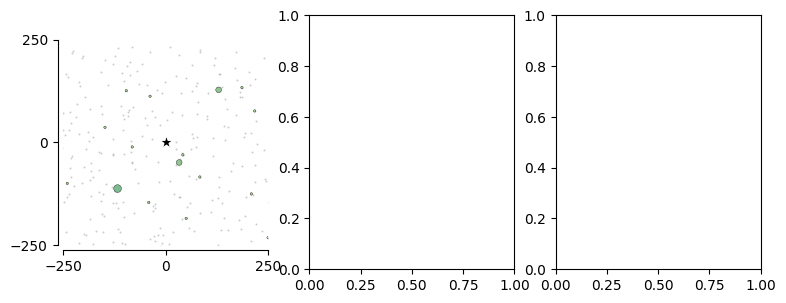

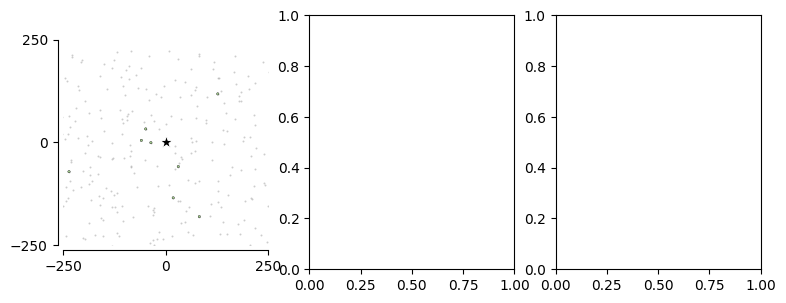

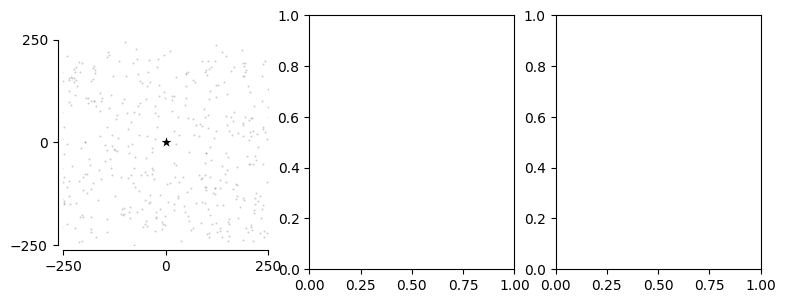

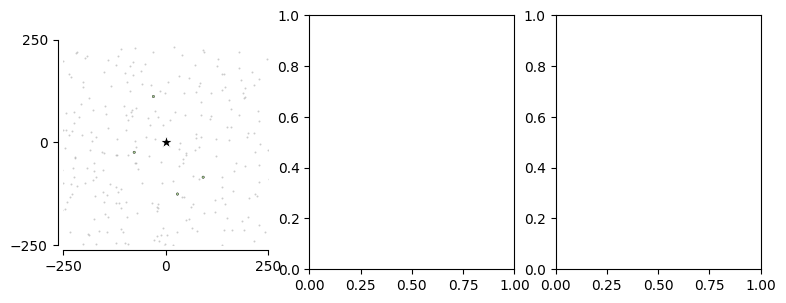

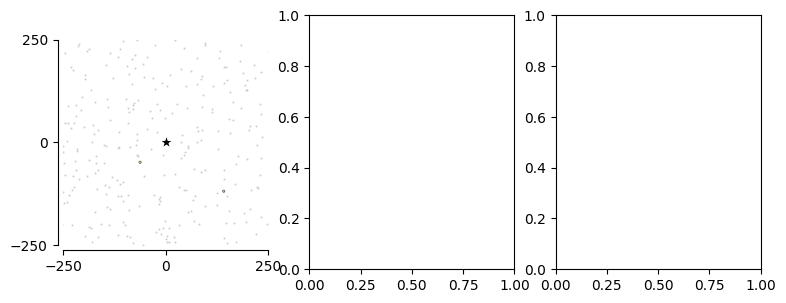

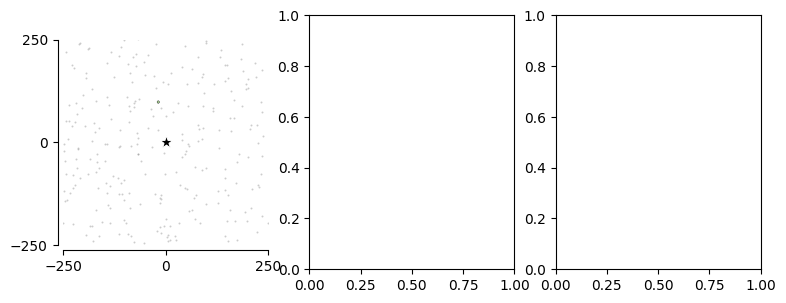

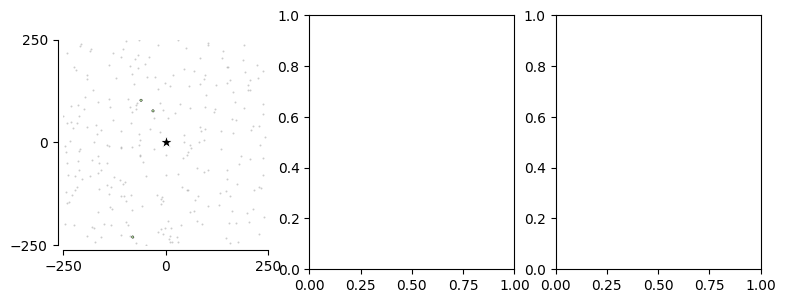

In [23]:
cell_ids = []
root_ids = []
soma_positions = []
target_ct = []
pmaxes = []
sigmas = []
mus = []
pre_ct = "L23"
for cell_id in tqdm.tqdm(nuc_ids_23):
    temp_df = client.materialize.tables.nucleus_detection_v0(
        id=cell_id
    ).query(desired_resolution=[1,1,1])
    root_id = temp_df['pt_root_id'].values[0]
    soma_position = temp_df['pt_position'].values[0]

    syn_df = client.materialize.tables.synapses_pni_2(pre_pt_root_id=root_id).query(
        split_positions=True, desired_resolution=[1, 1, 1]
    )
    syn_df = syn_df.query("pre_pt_root_id!=post_pt_root_id").reset_index(drop=True)

    soma_position, syn_df, target_df, connected, not_connected, bins = get_cell_tables(
        root_id, 
        syn_df,
        soma_df,
        minnie_ds,
        soma_position=soma_position,
    )
    
    syn_df = client.materialize.tables.synapses_pni_2(pre_pt_root_id=root_id).query(
        split_positions=True, desired_resolution=[1, 1, 1]
    )
    syn_df = syn_df.query("pre_pt_root_id!=post_pt_root_id").reset_index(drop=True)

    soma_position, syn_df, target_df, connected, not_connected, bins = get_cell_tables(
        root_id, 
        syn_df,
        soma_df,
        minnie_ds,
        soma_position=soma_position,
    )
    
    for ct in tqdm.tqdm(all_cell_types):
        try:
            params, fit_vals = fit_distance_parameters(
                ct,
                connected,
                not_connected,
                target_df,
                bins,
            )

            fig, axes = plot_ct_triplet(
                ct,
                params,
                fit_vals,
                soma_position,
                target_df,
                sizes=(3,200),
                figsize=(9,3.3),
                dpi=100,
            )

            fig.suptitle(f'Cell ID: {cell_id}'+r"$\rightarrow$"+f'{ct}')
            fig.tight_layout()
            fig.savefig(f"{plot_dir}/pre_{pre_ct}_{cell_id}_{root_id}_target_{ct}.png")
            plt.close(fig)
            cell_ids.append(cell_id)
            root_ids.append(root_id)
            soma_positions.append(soma_position)
            target_ct.append(ct)
            pmaxes.append(params[0])
            sigmas.append(params[1])
            mus.append(params[2])
        except:
            cell_ids.append(cell_id)
            root_ids.append(root_id)
            soma_positions.append(soma_position)
            target_ct.append(ct)
            pmaxes.append(np.nan)
            sigmas.append(np.nan)
            mus.append(np.nan)

The following functions will take the tables generated above and split them into class-specific or type-specific tables. 

 - `r_interval` is the bin width for each radial ring (in microns)
 - `up`, again in microns, is the upper (radial) distance limit away from your pre-synaptic cell
 - Optional `threshold` in microns is the distance away at least one of the synapses needs to be from the target cell's soma
 

The tables will be referenced as such: 

- `main_class[0]` will contain two class-specific tables for your first pre-synaptic root_id
- `syn_types[1][3]` will contain a single table of cells of the fourth specific type for your second pre-synaptic root_id, and only contain the ones connected to your pre-syn cell
- `f_type` contains the number of cells per bin not connected (failure) within the radial distance bin, and 
- `s_type` contains the number of cells per bin that IS connected (success) with that bin

In [ ]:
r_interval = 25
up = 400
threshold = 40
main_types, syn_types, nonsyn_types, f_type, s_type = make_tables.final_prep(
    main, syn, nonsyn, r_interval, up
)
# main_thresh,syn_thresh,nonsyn_thresh,main_types_thresh,syn_types_thresh,nonsyn_types_thresh,f_type_thresh,s_type_thresh = make_tables.final_prep(main,syn,nonsyn,r_interval,up,threshold=threshold)

Finally, this cell will create a pdf of the 33-panel plot for each pre-synaptic root_id inside of the table `pre`. 

#### Parameters:
    
1. `client` defined at the start
2. `pre` is the pre-synaptic table (just one row)
3. `main` is the entire table
4. `syn_types` is the synaptic table split into types
5. `nonsyn_types` is the non-synaptic table, also split into types
6. `s_type` is any array containing the number of successful connections to single somas per radial distance bin, generated above.
7. `f_type` is any array containing the number of unconnected cells per radial distance bin, generated above.
8. `r_interval` is the number of microns in a bin interval, depending on how it was defined in a previous cell
9. `upper_distance_limit` defined in a previous cell,

#### Optional Parameters:

10. `MLEresults`, default=True, will plot the model's estimation of pmax
11. `threshold`, default=None, defined in a previous cell,
12. `display`, default=False. If True, it will display the plot(s) in the notebook and will NOT save as pdf.

In [ ]:
plot.makepdfs(client,pre,main,syn_types,nonsyn_types,s_type,f_type,r_interval,up,True)
#plot.makepdfs(client,pre,main,syn_types_thresh,nonsyn_types,s_type_thresh,f_type_thresh,r_interval,up,threshold)

For displaying in the notebook, you can use this:

In [ ]:
def pmax(success, fail):
    return np.max(np.nan_to_num( success / (success+fail) ))

In [ ]:

pmax(conned[ct], not_conned[ct])

In [ ]:
target_df.query('cell_type==@ct and num_syn > 0')

In [ ]:
r.x

In [ ]:
plot.threepanels_pertype(
    

In [ ]:
filename = "test"
cell = 0
plot.threepanels_pertype(
    main[cell],
    pre[cell],
    syn_types[cell],
    nonsyn_types[cell],
    s_type[cell],
    f_type[cell],
    r_interval,
    up,
    filename,
    display=True,
)